## init

In [12]:
import pandas as pd
import numpy as np
from trial_utils import load_animal_df, filter_missing_from_df, save_fig as save_fig_as_pdf, plot_mean_scores_pp
import datetime
import matplotlib.pyplot as plt
from typing import List, Tuple, Literal, Optional
from detect_turn import (resolve_turn_config, plot_trial_heatmap_and_traces_from_results, TurnConfig, load_results_bundle,
                         shift_fig_axis)
from pathlib import Path
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
mpl.rcParams["font.family"] = "Helvetica"
mpl.rcParams['axes.labelsize'] = 10   # x/y label font size
mpl.rcParams['xtick.labelsize'] = 8   # x ticks font size
mpl.rcParams['ytick.labelsize'] = 8   # y ticks font size
mpl.rcParams['legend.fontsize'] = 8
mpl.rcParams['font.size'] = 8
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = False    # Ticks on top
mpl.rcParams['ytick.right'] = False  # Ticks on right
from turn_helpers import AnimalSpec, plot_animal_heatmaps, run_all_animals, run_model_for_animal

In [5]:
#---------------------------- animal configurations ----------------------------#        

ANIMALS: List[AnimalSpec] = [
    AnimalSpec(
        key="pv129",
        experiment="size_invariance",
        sil_subfolder="2025-12-10",
        cache_df_path="../data/PV129_2025-12-10_size_invariance_all_angle_windows.parquet",
        labels=[
            {"trial_id": 30413, "trial_side": "left", "turn_time_expect": 5.0, "strength": "weak"},
            {"trial_id": 31598, "trial_side": "left", "turn_time_expect": 1.5, "strength": "moderate"},
            {"trial_id": 30542, "trial_side": "left", "turn_time_expect": 0.2, "strength": "noticable"},
            {"trial_id": 30317, "trial_side": "left", "turn_time_expect": 3.0, "strength": "strong"},
            {"trial_id": 30321, "trial_side": "left", "turn_time_expect": 0.5, "strength": "strong"},
            {"trial_id": 30411, "trial_side": "left", "turn_time_expect": 5.5, "strength": "strong"}, 
            {"trial_id": 30261, "trial_side": "right", "turn_time_expect": 0.8, "strength": "strong"},
            {"trial_id": 30134, "trial_side": "right", "turn_time_expect": -0.9, "strength": "strong"},
            {"trial_id": 30303, "trial_side": "right", "turn_time_expect": 3.8, "strength": "moderate"},
            {"trial_id": 30808, "trial_side": "right", "turn_time_expect": 5.8, "strength": "strong"},
            {"trial_id": 30498, "trial_side": "right", "turn_time_expect": 1.0, "strength": "noticable"},
            {"trial_id": 31188, "trial_side": "left", "turn_time_expect": [-0.1, 2, 4.2],  "strength": "noticable"},
            {"trial_id": 30993, "trial_side": "left", "turn_time_expect": [2, 3],  "strength": "noticable"},
        ],
        cfg = TurnConfig(
            plot_time_range=(-4, 6),
            ml_lags=15,
            sort_rows=True,
            bin_size=0.05,
            smooth_roll_bins_classic=15,
            ml_pp_baseline_mode="none",
            ml_pp_thresh_mode="fixed",
            ml_pp_thresh_fixed=0.6,
            postproc_smooth_bins=1,
        )
    ),

    AnimalSpec(
        key="pv91",
        experiment="basic_color",
        sil_subfolder="EXPECTATIONS_PHASE",
        cache_df_path="../data/PV91_EXPECTATIONS_PHASE_basic_color_all_angle_windows.parquet",
        labels=[
            {"trial_id": 5651, "trial_side": "left", "turn_time_expect": [1.5], "strength": "strong"},
            {"trial_id": 6551, "trial_side": "left", "turn_time_expect": [9, 12], "strength": "strong"},
            {"trial_id": 7130, "trial_side": "left", "turn_time_expect": 5, "strength": "strong"},
            {"trial_id": 6522, "trial_side": "left", "turn_time_expect": [1, 7, 18], "strength": "strong"},
            {"trial_id": 6551, "trial_side": "left", "turn_time_expect": [-1, 9, 12], "strength": "strong"},
            {"trial_id": 7138, "trial_side": "left", "turn_time_expect": [4, 5, 7, 13], "strength": "strong"},
            {"trial_id": 5975, "trial_side": "right", "turn_time_expect": [1, 11], "strength": "strong"},
            {"trial_id": 5781, "trial_side": "right", "turn_time_expect": [0.5, 1], "strength": "strong"},
            {"trial_id": 5958, "trial_side": "right", "turn_time_expect": [3], "strength": "strong"},
        ],
        cfg=TurnConfig(
            plot_time_range=(-5, 5),
            smooth_roll_bins_classic=20,
            ml_lags=15,
            sort_rows=True,
            bin_size=0.2,
            ml_pp_thresh_fixed=0.5,
            postproc_apply_to_heatmaps=True,
            plot_row_height=0.1,
        ),
    ),
    
    AnimalSpec(
        key="pv80",
        experiment="basic_color",
        sil_subfolder="fail_back",
        cache_df_path="../data/PV80_fail_back_basic_color_all_angle_windows.parquet",
        env_file=".pv80.env",
        labels=[
            {"trial_id": 10087, "trial_side": "left", "turn_times_expect": [3.0, 10.5], "strength": "strong"},
            {"trial_id": 10088, "trial_side": "left", "turn_times_expect": [5.0], "strength": "strong"},
            {"trial_id": 10090, "trial_side": "left", "turn_times_expect": [4.0], "strength": "noticable"},
            {"trial_id": 10084, "trial_side": "left", "turn_times_expect": [2.0], "strength": "strong"},
            {"trial_id": 10085, "trial_side": "left", "turn_times_expect": [3.5], "strength": "moderate"},
            {"trial_id": 10091, "trial_side": "left", "turn_times_expect": [1.0], "strength": "weak"},
            {"trial_id": 10096, "trial_side": "left", "turn_times_expect": [5.0, 6.2], "strength": "moderate"},
            {"trial_id": 10083, "trial_side": "right", "turn_times_expect": [5.0], "strength": "full"},
            {"trial_id": 10086, "trial_side": "right", "turn_times_expect": [7.0], "strength": "nice"},
            {"trial_id": 10089, "trial_side": "right", "turn_times_expect": [11.0], "strength": "strong"},
            {"trial_id": 10095, "trial_side": "right", "turn_times_expect": [5.0], "strength": "moderate"},
            {"trial_id": 10130, "trial_side": "right", "turn_times_expect": [0.5], "strength": "strong"},
            {"trial_id": 10144, "trial_side": "right", "turn_times_expect": [14.0], "strength": "strong"},
        ],
        cfg=TurnConfig(plot_time_range=(-5, 15), bin_size=0.05, ml_diff_k_bins=10),
    ),
    AnimalSpec(
        key="pv163",
        experiment="color_constancy",
        cache_df_path="../data/PV163_2025-12-10_color_constancy_all_angle_windows.parquet",
        sil_subfolder="2025-12-10",
        labels=[
            {"trial_id": 5907, "trial_side": "left", "turn_time_expect": 6, "strength": "strong"},
            {"trial_id": 5908, "trial_side": "left", "turn_time_expect": 6, "strength": "strong"},
            {"trial_id": 6380, "trial_side": "left", "turn_time_expect": 3, "strength": "strong"},
            {"trial_id": 5909, "trial_side": "left", "turn_time_expect": 7, "strength": "strong"},
            {"trial_id": 5910, "trial_side": "left", "turn_time_expect": 7.2, "strength": "strong"},
            {"trial_id": 6467, "trial_side": "left", "turn_time_expect": 20.5, "strength": "strong"},
            {"trial_id": 6735, "trial_side": "left", "turn_time_expect": 5.4, "strength": "strong"},
            {"trial_id": 6466, "trial_side": "right", "turn_time_expect": 18, "strength": "strong"},
            {"trial_id": 6916, "trial_side": "left", "turn_time_expect": 4, "strength": "strong"},
            {"trial_id": 6913, "trial_side": "left", "turn_time_expect": 3, "strength": "strong"},
            {"trial_id": 6736, "trial_side": "right", "turn_time_expect": 7.2, "strength": "strong"},
            {"trial_id": 6942, "trial_side": "right", "turn_time_expect": 5, "strength": "strong"},
        ],
        cfg = TurnConfig(
            plot_time_range=(-5, 5),
            ml_lags=10,
            smooth_roll_bins_classic=2,
            # ml_pp_thresh_fixed=0.5,
            sort_rows=True,
            bin_size=0.05,
            ml_pp_thresh_fixed=0.6,
            plot_row_height=0.05
        )
    ),
    AnimalSpec(
        key="pv75",
        experiment="trans+pos_invariance",
        sil_subfolder="2025-07-23--2025-12-13",
        cache_df_path="../data/PV75_2025-07-23--2025-12-13_trans+pos_invariance_all_angle_windows.parquet",
        labels=[
            {"trial_id": 25139, "trial_side": "left", "turn_time_expect": [1.5], "strength": "strong"},
            {"trial_id": 25239, "trial_side": "left", "turn_time_expect": [-0.8, 2], "strength": "strong"},
            {"trial_id": 26135, "trial_side": "left", "turn_time_expect": 5, "strength": "strong"},
            {"trial_id": 26943, "trial_side": "left", "turn_time_expect": 0.5, "strength": "strong"},
            {"trial_id": 25607, "trial_side": "right", "turn_time_expect": 5, "strength": "strong"},
            {"trial_id": 26288, "trial_side": "right", "turn_time_expect": 6, "strength": "strong"},
            {"trial_id": 27109, "trial_side": "left", "turn_time_expect": [5.5, 7, 8, 9], "strength": "strong"},
            {"trial_id": 27112, "trial_side": "left", "turn_time_expect": 2, "strength": "strong"},
        ],
        cfg=TurnConfig(
            plot_time_range=(-5, 5),
            smooth_roll_bins_classic=20,
            ml_lags=15,
            sort_rows=True,
            bin_size=0.2,
            ml_pp_thresh_fixed=0.5,
            postproc_apply_to_heatmaps=True,
        ),
    ),

]

get_animal_spec = lambda key: next((animal for animal in ANIMALS if animal.key == key), None)

In [6]:
def remove_top_right_frames(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [7]:
def load_all_animals_df(animal_ids):
    all_animals_df = pd.DataFrame()
    for animal_id in animal_ids:
        data_path = get_animal_spec(animal_id).cache_df_path
        animal = load_animal_df(animal_id, data_path=data_path)
        all_animals_df = pd.concat([all_animals_df, animal.df], ignore_index=True)
    return all_animals_df

/Users/regev/PhD/msi/Pogona_Pursuit/head_turn_detection/src/turn_helpers.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)
1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


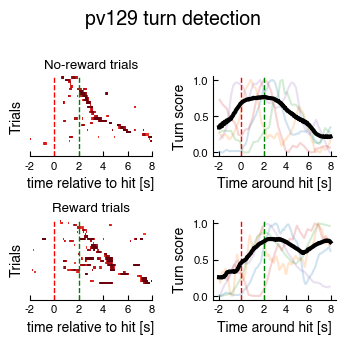

In [14]:
example_animal = 'pv129'
FIGURE_PATH = '/Users/regev/PhD/internal_models_paper'
out_dir = Path("../output/turn_scores_all_animals")
res = load_results_bundle(out_dir / "results" / example_animal)
scores_df = pd.read_parquet(out_dir / "all_animals_scores.parquet")
cfg = res.get("cfg") or resolve_turn_config(get_animal_spec(example_animal).cfg)
score_col = "turn_score_pp" if cfg["POSTPROC_APPLY_TO_HEATMAPS"] else "turn_score_nms"
fig, axes = plt.subplots(2, 2, figsize=(3.5, 3.3))

plot_animal_heatmaps(
    scored_df=res["scored_ml"],
    meta_df=res["meta"],
    cfg=cfg,
    score_col=score_col,
    title_prefix=f"{example_animal} turn detection",
    is_shift_req=True,
    shift=2,
    is_legend=False,
    ax_reward=axes[1, 0],
    ax_no_reward=axes[0, 0]
)
for i in range(2):
    axes[i, 0].set_yticks([])
    axes[i, 0].set_ylabel('Trials')
    axes[i, 0].spines['bottom'].set_visible(True)
    axes[i, 0].set_xticks([0, 40, 80, 120, 160, 200], [-2, 0, 2, 4, 6, 8])

for i, trial_type in enumerate(["no_reward", "reward"]):
    _, rolling_df = plot_mean_scores_pp(
        scores_df,
        trial_type=trial_type,
        range_start=-4,
        range_end=6,
        roll_window_s=1.5,
        mean_smooth_window_s=2.5,
        is_legend=False,
        ax=axes[i, 1]
    )
    remove_top_right_frames(axes[i, 1])
    dt = datetime.datetime.now().strftime("%Y%m%d%H%M")
    axes[i, 1].set_xticks([-4, -2, 0, 2, 4, 6], [-2, 0, 2, 4, 6, 8])


fig.tight_layout()
fig.savefig(f'{FIGURE_PATH}/figures/head_turn_fig.pdf')

## figure plots

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


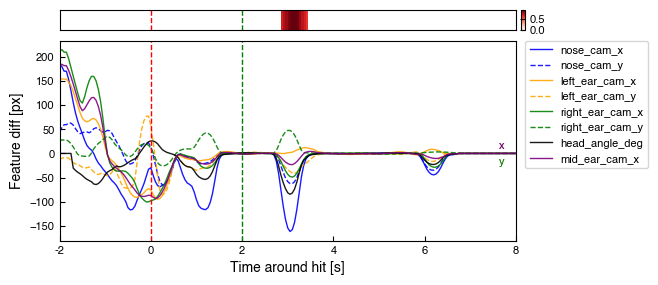

In [9]:
animal_id = "pv129"
trial_id = 30284
date_tag="t"
pv_results = load_results_bundle(Path(out_dir) / "results" / "pv129")
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
plot_trial_heatmap_and_traces_from_results(
    results=pv_results,
    trial_id=trial_id,
    feature_mode="diff",
    time_range=(-4, 6),
    cfg={"PLOT_ALIGN_X_BY_SIDE": False, "PLOT_FILL_TRAILING": True},
    ax=ax
)
fig = shift_fig_axis(fig, 2, "hit")
fig.savefig(f'{FIGURE_PATH}/figures/head_turn_single_trial.pdf')

## Frames Example

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


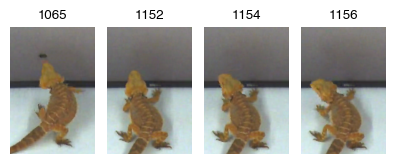

In [11]:
cap = cv2.VideoCapture('../data/back_20230531T113504.mp4')
start_frame = 1065
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
frames = [start_frame, 1152, 1154, 1156]
n_frames = len(frames)
fig, axes = plt.subplots(1, n_frames, figsize=(1 * n_frames, 1 * 2))
i = 0
for frame_id in range(frames[-1] - start_frame + 1):
    ret, frame = cap.read()
    if frame_id + start_frame in frames:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # frame = frame[100:500, 300:1000]
        frame = frame[200:500, 550:750]
        frame = cv2.convertScaleAbs(frame, alpha=1.3, beta=30)
        kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
        frame = cv2.filter2D(frame, -1, kernel)
        frame = cv2.resize(frame, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)  # upscale
        frame = cv2.bilateralFilter(frame, d=9, sigmaColor=75, sigmaSpace=75)  # edge-preserving smoothing
        axes[i].imshow(frame)
        axes[i].axis('off')
        axes[i].set_title(f"{frame_id + start_frame}")
        i += 1
fig.tight_layout()
fig.savefig(f'{FIGURE_PATH}/figures/head_turn_frames_example.pdf')

## run all ppl

In [7]:
%matplotlib inline

animal_ids = ["pv129", "pv91", "pv75", "pv80", "pv163"]
# animal_ids = ["pv129"]
out_dir = Path("../output/turn_scores_all_animals") #Path("../output/turn_scores_all_animals")
src_dir = out_dir
import datetime
SAVE_MODELS = True

out_dir.mkdir(parents=True, exist_ok=True)
scores_fname = src_dir / "all_animals_scores.parquet"
reload = False
import os
if not os.path.exists(scores_fname) or reload:
    scores_df, animal_df, results = run_all_animals(animal_ids,     ANIMALS, out_dir=out_dir,
                                run_side=False,
                                  run_loto=False,
                                use_new_side_v=False, save_models=SAVE_MODELS)
else:
    print("Loading existing scores...")
    scores_df = pd.read_parquet(scores_fname)
    results = pd.DataFrame()
    for animal_id in animal_ids:
        results[animal_id] = load_results_bundle(
        src_dir / "results" / animal_id,
        tables=["scored_ml", "meta", "trial_sides_pred", "cfg"]  # feat_ml is heavy
    )
    all_animals_df = load_all_animals_df(animal_ids)


    # fig, (ax_nr, ax_r) = plt.subplots(ncols=2, figsize=(15, 4))
    # cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])

    
    # replot per animal
    for animal_id in animal_ids:
        res = results[animal_id]
        cfg = res.get("cfg") or resolve_turn_config(get_animal_spec(animal_id).cfg)
        score_col = "turn_score_pp" if cfg["POSTPROC_APPLY_TO_HEATMAPS"] else "turn_score_nms"

        figs = plot_animal_heatmaps(
            scored_df=res["scored_ml"],
            meta_df=res["meta"],
            cfg=cfg,
            score_col=score_col,
            title_prefix=f"{animal_id} turn detection",
            is_shift_req=True,
            shift=2,
            is_legend=False,

        )
        # for fig in figs:
        #     display(fig)
        # plt.close(fig)


=============Processing animal: pv129==============
Loaded cached results for pv129
=============Processing animal: pv91==============
Filtered out trials with missing data after 0s: [5466, 5467, 5571, 5592, 5642, 5644, 5652, 5983, 6364, 6552, 6553, 6554, 7219]


/Users/regev/PhD/msi/Pogona_Pursuit/head_turn_detection/src/turn_helpers.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


=============Processing animal: pv75==============
Filtered out trials with missing data after 0s: [24954, 24965, 25140, 25141, 25366, 25481, 25610, 25677, 25695, 25705, 25926, 26011, 26024, 26104, 26205, 26235, 26262, 26274, 26341, 26365, 26379, 26709, 26946, 27107, 27110, 27288, 27484, 27496, 27504, 27518, 27561, 27870]


/Users/regev/PhD/msi/Pogona_Pursuit/head_turn_detection/src/turn_helpers.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


=============Processing animal: pv80==============
Filtered out trials with missing data after 0s: [10099, 10296, 10433, 12462, 12631, 13138, 13321]


/opt/miniconda3/envs/prey_touch/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/regev/PhD/msi/Pogona_Pursuit/head_turn_detection/src/turn_helpers.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


=============Processing animal: pv163==============
Filtered out trials with missing data after 0s: [5963, 6381, 6433, 6642, 6856, 6880, 6888, 6899, 6926, 6941]


/Users/regev/PhD/msi/Pogona_Pursuit/head_turn_detection/src/turn_helpers.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


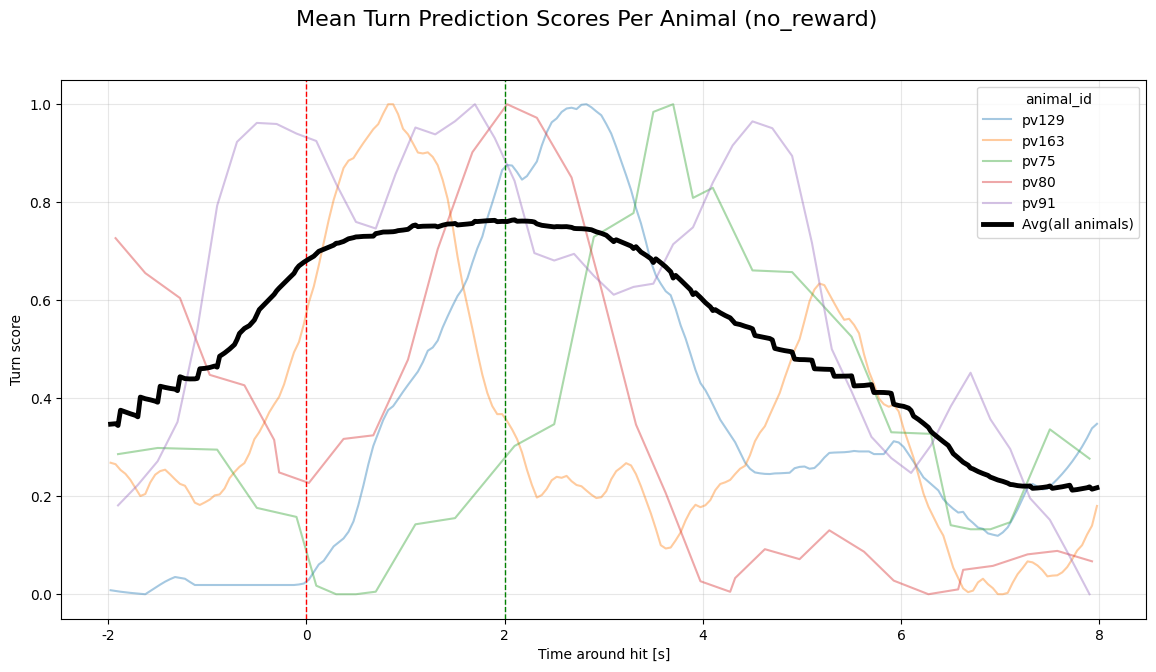

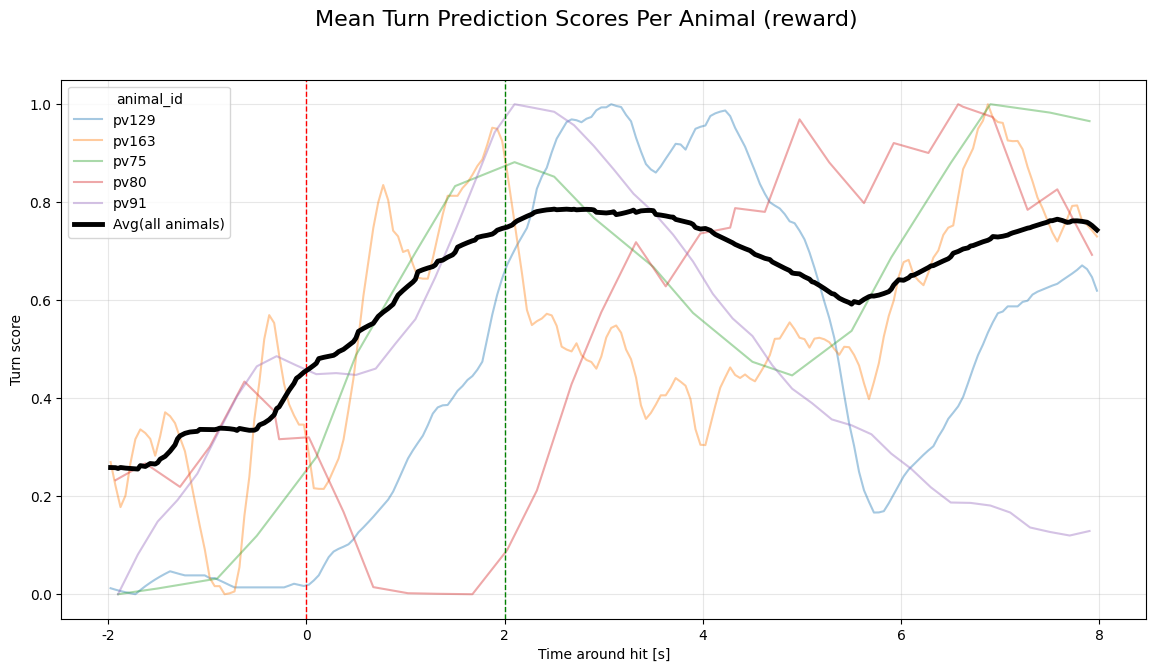

In [8]:
for trial_type in ["no_reward", "reward"]:
    fig, rolling_df = plot_mean_scores_pp(
        scores_df,
        trial_type=trial_type,
        range_start=-4,
        range_end=6,
        roll_window_s=1.5,
        mean_smooth_window_s=2.5,
        # is_legend=False
    )
    dt = datetime.datetime.now().strftime("%Y%m%d%H%M")

    # add title to fig 
    fig.suptitle(f"Mean Turn Prediction Scores Per Animal ({trial_type})", fontsize=16)
    save_fig_as_pdf(fig, out_dir / "figs", save_prefix=f"mean_turn_scores_{trial_type}_{dt}", use_datestamp=False)
    display(fig)

## specific animal trial

In [9]:
animal_id = "pv129"
trial_id=30284
date_tag="t"
pv_results = load_results_bundle(Path(src_dir) / "results" / "pv129")


/Users/regev/PhD/msi/Pogona_Pursuit/head_turn_detection/src/detect_turn.py:2889: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


../output/turn_scores_all_animals/figs


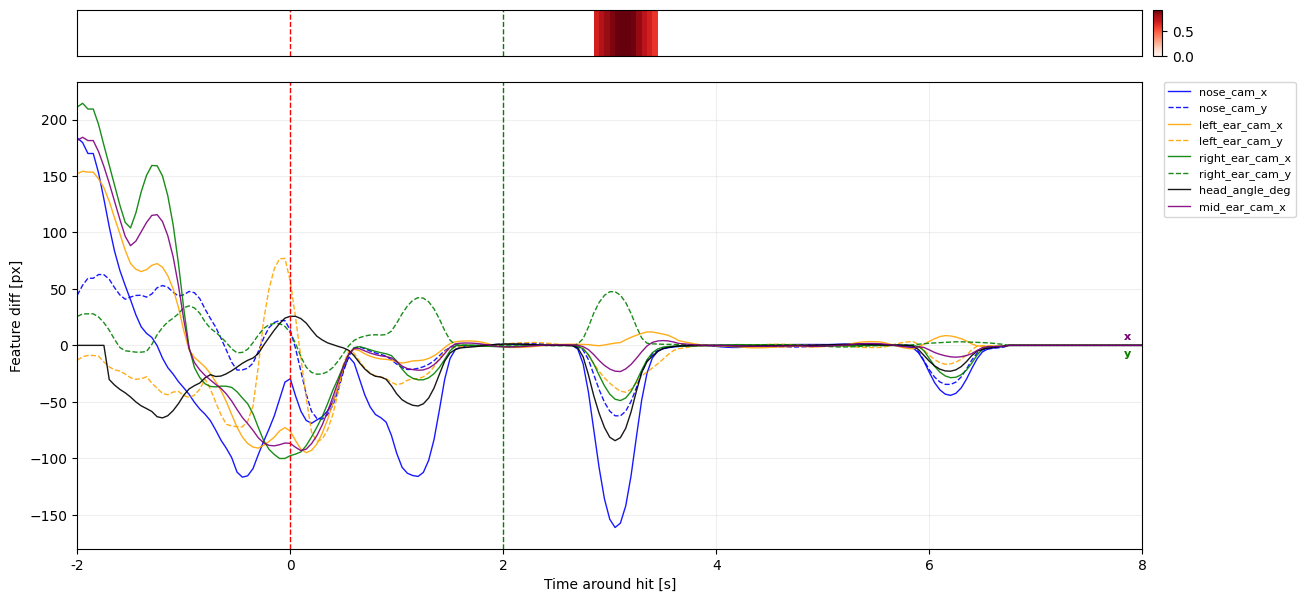

In [10]:
from detect_turn import plot_trial_heatmap_and_traces_from_results
fig = plot_trial_heatmap_and_traces_from_results(
    results=pv_results,
    trial_id=trial_id,
    feature_mode="diff",
    time_range=(-4, 6),
    cfg={
        "PLOT_ALIGN_X_BY_SIDE": False,
        "PLOT_INTERP_MISSING": True,
        "PLOT_FILL_TRAILING": True,
    },
)


path = Path(out_dir / "figs")
prefix = f"{animal_id}_trial_{trial_id}_heatmap_traces_{date_tag}"
save_fig_as_pdf(fig, path, save_prefix=prefix, use_datestamp=False)
print(path)
from IPython.display import display

display(fig)

# ROC

In [33]:
results_dir = out_dir / "results"

# fast path: use precomputed scores (no recompute)
scores_df = pd.read_parquet(out_dir / "all_animals_scores.parquet")


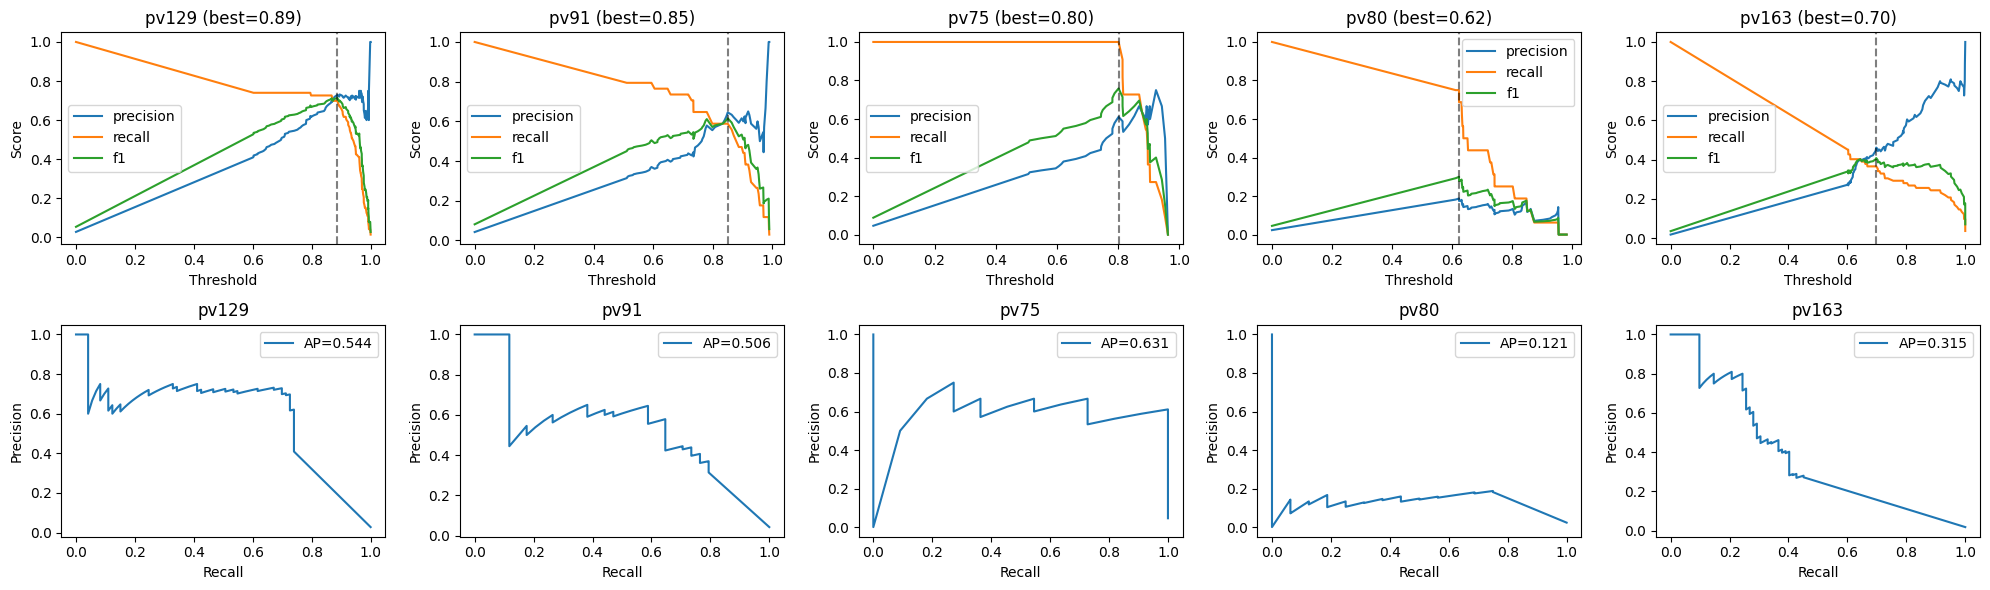

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path


from detect_turn import resolve_cfg, compute_turn_pr_auc, load_results_bundle, make_labels_df

def get_results_bundle(aid, *, results=None, results_dir=None, tables=None):
    if isinstance(results, dict):
        # Dict keyed by animal id
        res_i = results.get(aid)
        if res_i is None:
            res_i = results.get(str(aid).lower())
        if res_i is None:
            res_i = results.get(str(aid))
        if res_i is not None:
            return res_i

        if any(k in results for k in ("scored_ml", "feat_ml", "meta")):
            meta = results.get("meta")
            if isinstance(meta, pd.DataFrame) and "animal_id" in meta.columns:
                meta_aids = meta["animal_id"].dropna().unique().tolist()
                if len(meta_aids) == 1 and str(meta_aids[0]).lower() == str(aid).lower():
                    return results
    if results_dir is None:
        raise ValueError("results_dir not set; run the cell that defines results_dir or out_dir")
    return load_results_bundle(Path(results_dir) / aid, tables=tables)


# ---- per-animal PR/AP plot ----
def plot_roc_all_animals(
    animal_ids: List[str],
    is_legend: bool = True,
    *,
    legend_outside: bool = False,
    legend_ncol: int = 1,
    legend_fontsize: int = 8,
    legend_panel_width: float = 1.6,
):
    rows = []
    if is_legend and legend_outside:
        fig = plt.figure(figsize=(5 + float(legend_panel_width), 3*len(animal_ids)))
        gs = fig.add_gridspec(len(animal_ids), 3, width_ratios=[5, 5, float(legend_panel_width)], wspace=0.5, hspace=1)
        axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1])]
        leg_ax = fig.add_subplot(gs[0, 2])
        leg_ax.axis("off")
    else:
        fig, axes = plt.subplots(2, len(animal_ids), figsize=(4*len(animal_ids), 6))
        leg_ax = None

    results_obj = globals().get("results", None)
    results_dir_obj = globals().get("results_dir", None)

    for i, aid in enumerate(animal_ids):
        res_i = get_results_bundle(
            aid,
            results=results_obj,
            results_dir=results_dir_obj,
            tables=["scored_ml", "feat_ml", "meta"],
        )

        if res_i.get("labels_df") is None or res_i["labels_df"].empty:
            spec = get_animal_spec(aid)
            cfg_i = resolve_cfg(res_i.get("cfg"))
            res_i["labels_df"] = make_labels_df(spec.labels, cfg=cfg_i)

        # Get precision-recall data with thresholds
        ap, precision, recall, thresholds = compute_turn_pr_auc(res_i)
        
        # Calculate F1 score (beta=1)
        if precision is not None and thresholds is not None:
            beta = 1
            fbeta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall + 1e-10)
            best_idx = np.nanargmax(fbeta[:-1])  # exclude last element which corresponds to threshold=0
            best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5
            
            # Plot threshold curves
            axes[0, i].plot(thresholds, precision[:-1], color='tab:blue', label='precision')
            axes[0, i].plot(thresholds, recall[:-1], color='tab:orange', label='recall')
            axes[0, i].plot(thresholds, fbeta[:-1], color='tab:green', label='f1')
            axes[0, i].axvline(best_threshold, ls='--', color='k', alpha=0.5)
            axes[0, i].legend(fontsize=10)
            axes[0, i].set_title(f'{aid} (best={best_threshold:.2f})', fontsize=12)
            axes[0, i].set_xlabel('Threshold', fontsize=10)
            axes[0, i].set_ylabel('Score', fontsize=10)
        
        # Plot PR curve
        rows.append({"animal_id": aid, "ap": ap})
        if precision is not None:
            axes[1, i].plot(recall, precision, label=f"AP={ap:.3f}")
            axes[1, i].legend(fontsize=10)
            axes[1, i].set_xlabel("Recall", fontsize=10)
            axes[1, i].set_ylabel("Precision", fontsize=10)
            axes[1, i].set_title(f"{aid}", fontsize=12)

    ap_df = pd.DataFrame(rows).sort_values("animal_id")
    if not legend_outside:
        fig.tight_layout()
    
    return fig, ap_df


fig, ap_df = plot_roc_all_animals(
    ["pv129", "pv91", "pv75", "pv80", "pv163"],
    is_legend=True,
    legend_outside=False,
    legend_fontsize=7,
)
display(fig)
display(ap_df)


Saved threshold plot to ../output/turn_scores_all_animals/evaluations/threshold_sweep.png


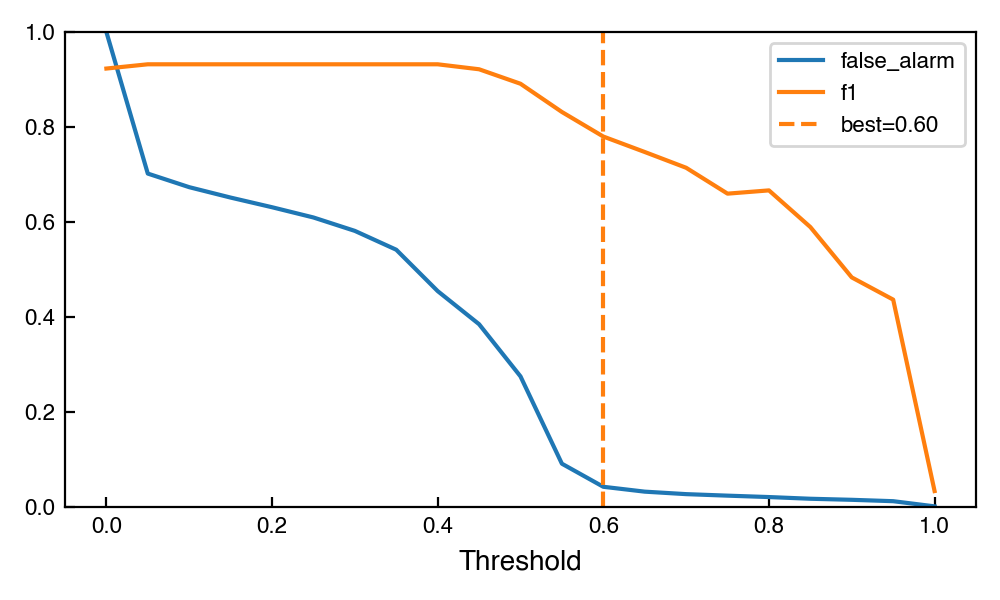

best_f1: 0.78


In [8]:
import numpy as np
from IPython.display import Image, display
from detect_turn import sweep_turn_thresholds_for_animals, build_threshold_summary, plot_threshold_sweep
import os

# Ensure we're using the correct output directory
if 'out_dir' not in dir() or str(out_dir) == "output/turn_scores_no_side":
    print("Warning: out_dir not set correctly. Using ../output/turn_scores_all_animals")
    out_dir = Path("../output/turn_scores_all_animals")

eval_dir = out_dir / "evaluations"
eval_dir.mkdir(parents=True, exist_ok=True)

thresholds = np.linspace(0.0, 1.0, 21)
df_sweep = sweep_turn_thresholds_for_animals(
    ANIMALS,
    results_dir=out_dir / "results",
    thresholds=thresholds,
    score_col="turn_score_rawprob",
    tol_s=1.0,
    true_window_s=0.1,
)

summary, best = build_threshold_summary(df_sweep)
summary.to_csv(eval_dir / "threshold_sweep_summary.csv", index=False)
df_sweep.to_csv(eval_dir / "threshold_sweep_raw.csv", index=False)
plot_threshold_sweep(summary, best, out_path=eval_dir / "threshold_sweep.png")

# Check if file exists before displaying
img_path = eval_dir / "threshold_sweep.png"
if os.path.exists(img_path):
    display(Image(filename=str(img_path)))
else:
    print(f"Warning: Plot file not found at {img_path}")

print("best_f1:", None if best is None else float(best.get("f1", float("nan"))))

# All Features

In [13]:
from pathlib import Path
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_recall_curve, average_precision_score

import detect_turn
from detect_turn import resolve_cfg

results_dir = out_dir / "results"

# fast path: use precomputed scores (no recompute)
scores_df = pd.read_parquet(out_dir / "all_animals_scores.parquet")

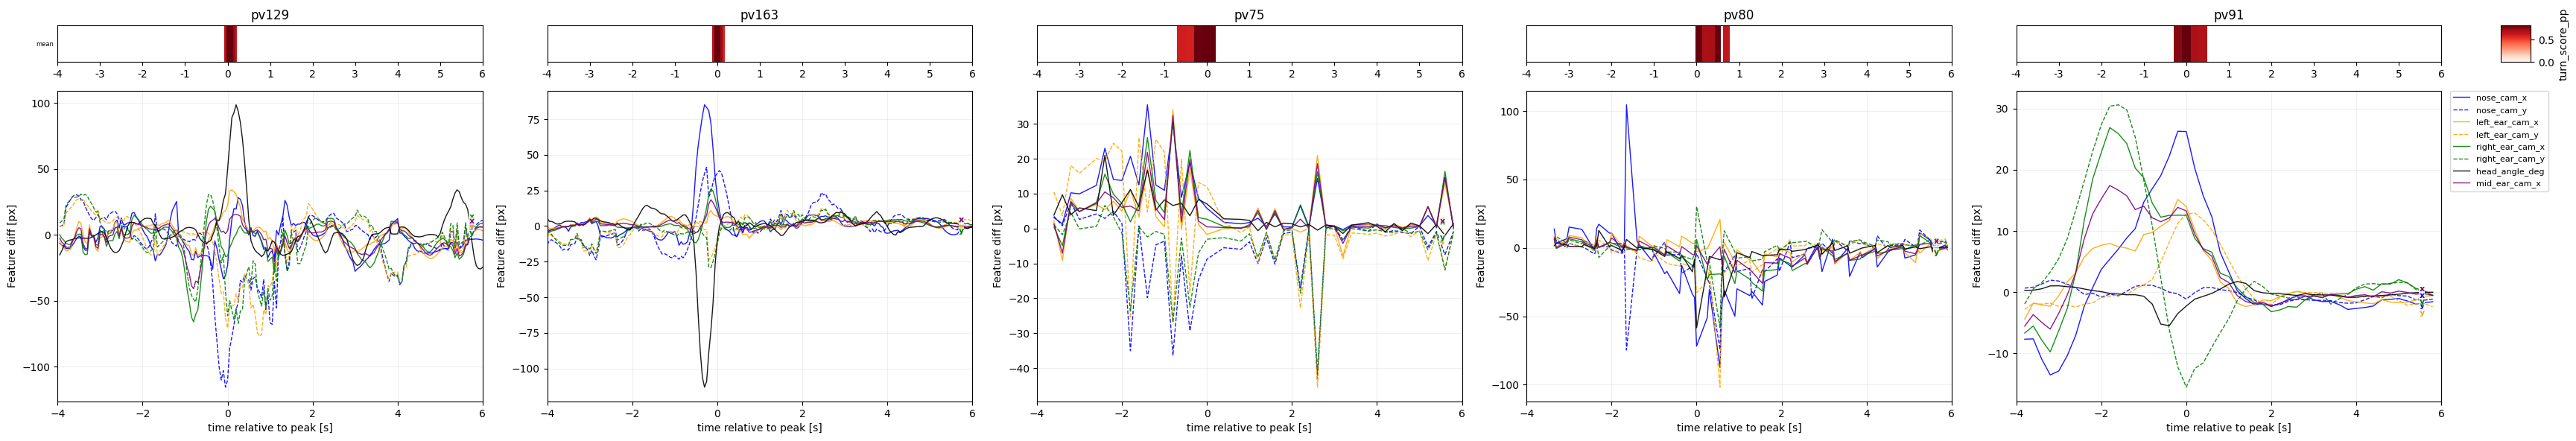

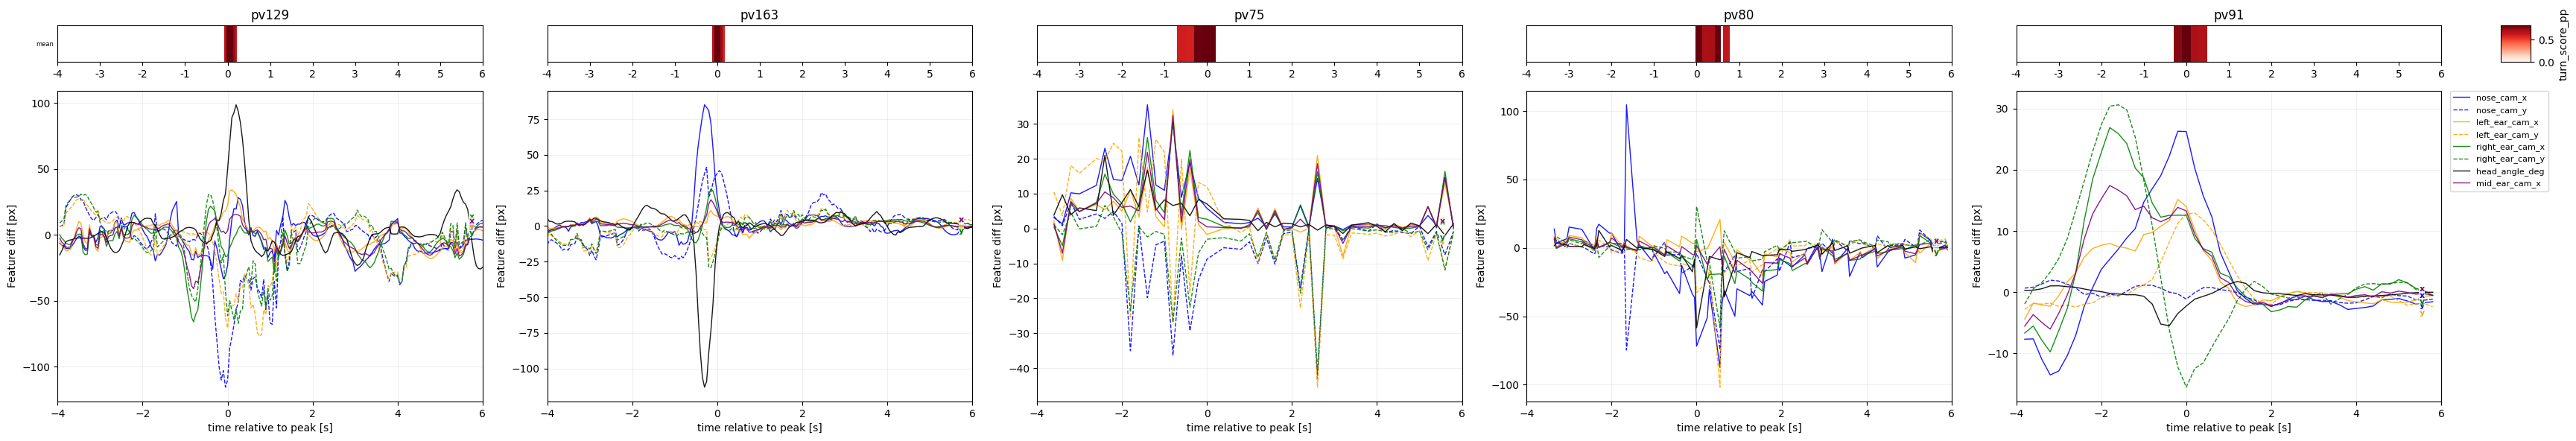

In [14]:
import matplotlib.pyplot as plt
from turn_helpers import plot_peak_aligned_mean_heatmaps

animal_ids = ["pv129", "pv163", "pv75", "pv80", "pv91"]
time_range = (-4, 6)
heatmap_min_score = 0.6

fig, heat_axes, trace_axes, value_label = plot_peak_aligned_mean_heatmaps(
    animal_ids=animal_ids,
    results_dir=results_dir,
    time_range=time_range,
    heatmap_min_score=heatmap_min_score,
    feature_mode="diff",
    row_height=0.01,
    trace_legend=True,
    trace_legend_last_only=True,
    trace_legend_outside=False,
)

fig


# Model Weights

In [45]:
import importlib, turn_helpers
importlib.reload(turn_helpers)

<module 'turn_helpers' from '/Users/bareketdamari/Dev/PreyTouch/sandbox/analysis/expectation/expectation_turn_head/code/turn_helpers.py'>

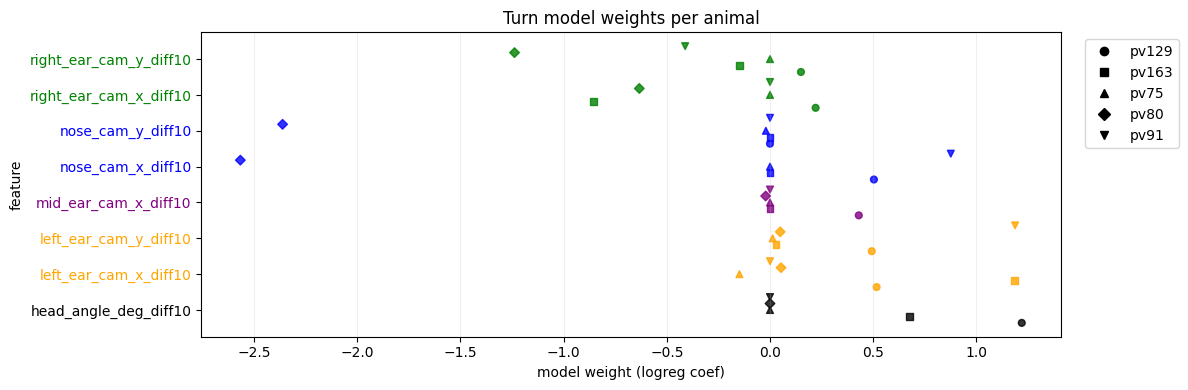

In [15]:
import numpy as np
import pandas as pd
from turn_helpers import collect_turn_model_weights, plot_model_weights_scatter

models_dir = (out_dir / "models")
weights_df = collect_turn_model_weights(models_dir)

apply_feature_filters = True  # set False to keep ALL features
simplify_labels = True 


plot_df = weights_df.copy()
if apply_feature_filters:
    plot_df = plot_df[~plot_df["feature"].str.contains("__lag", na=False)]
    plot_df = plot_df[~plot_df["feature"].str.contains("__abs", na=False)]
    has_diff = plot_df["feature"].str.contains("__diff", na=False).any()
    if has_diff:
        plot_df = plot_df[plot_df["feature"].str.contains("__diff", na=False)]
    else:
        plot_df = plot_df[plot_df["feature"].str.contains("__d1", na=False)]
    plot_df = plot_df[plot_df["feature"].str.contains("_cam_") | plot_df["feature"].str.contains("head_angle")]

# set top_n=None to show all features (can be large)
fig, ax = plot_model_weights_scatter(plot_df, top_n=30, simplify_labels=simplify_labels)
save_fig_as_pdf(fig, out_dir / "figs", save_prefix="turn_model_weights_scatter", use_datestamp=True)
fig



In [ ]:
# Complete this function:
def add(a, b):
    return a + b
